In [52]:
import os
import re
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path
from datetime import datetime

from PIL import Image as PILImage
import matplotlib.patches as patches

from MirrorExtractor.simple_mirror_extractor import SimpleMirrorExtractor
from MirrorFeatureExtractor.mirror_feature_extractor import MirrorFeatureExtractor

In [4]:
def mark_mirrors_on_img(img_path, points_list):
    img_bgr = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.imshow(img_rgb)

    for points in points_list:
        # === Polygon na podstawie 4 współrzędnych ===
        polygon = patches.Polygon(
                points,
                closed=True,
                linewidth=2,
                edgecolor='red',
                facecolor='red',
                alpha=0.3  # przezroczystość wypełnienia
            )
        ax.add_patch(polygon)

    plt.tight_layout()
    plt.show()

In [5]:
MY_COMP_OUTPUT_DIR_PATH = "/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/data/images_for_analysis"
my_comp_root = Path("/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/data/2025/10/")

BASE_DIR = "/home/pgliwny/Praca/Computer_vision_for_MAGIC/data"
ROOT = Path(BASE_DIR) / "data/images_for_analysis"
MIRROR_POINTS_JSON = Path(BASE_DIR) / "points_IRCam.json"

In [55]:
IMG_PATH = "/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/data/images_for_analysis/IRCamM1T20251005_075000M.jpg"
IMG_PATH = "/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/data/2025/12/15/IRCamM1T20251215_081547M.jpg"

images_paths = sorted(glob.glob("/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/data/images_for_analysis/*.jpg"))
n_images = len(images_paths)
print(n_images)

mirror_extractor = SimpleMirrorExtractor(str(MIRROR_POINTS_JSON))
mirror_feature_extractor = MirrorFeatureExtractor()

feature_names = ['lbp_entropy', 'glcm_contrast', 'glcm_dissimilarity',
                 'glcm_homogeneity', 'glcm_energy', 'glcm_correlation']

feature_matrix = np.zeros((n_images, 249, 6))  # wypełniasz w pętli po lustrach

for i, path in enumerate(images_paths):
    img_gray = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2GRAY)
    for mirror_id in range(0, 249):
        mirror_crop = mirror_extractor.extract_mirror_gray(img_gray, mirror_id=mirror_id)
        feat=mirror_feature_extractor.extract_texture_features(mirror_crop)
        feature_matrix[i, mirror_id] = list(feat.values())


25


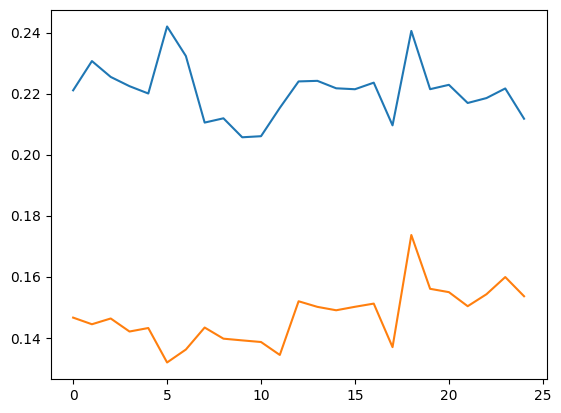

In [66]:
plt.plot(feature_matrix[:, 180, 3])
plt.plot(feature_matrix[:, 129, 3])

In [68]:
baseline_median = np.median(feature_matrix, axis=0)
baseline_mad = np.median(
    np.abs(feature_matrix - baseline_median[np.newaxis, :, :]),
    axis=0
)*1.4826

#Minum MAD żeby uniknąć dzielenia przez 0
baseline_mad = np.maximum(baseline_mad, 1e-6) #

In [143]:
# Compara baseline with new images
IMG_PATH = "/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/data/images_for_analysis/IRCamM1T20251005_075000M.jpg"
IMG_PATH = "/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/data/2025/12/15/IRCamM1T20251215_081547M.jpg"

new_feature_matrix = np.zeros((249, 6))
img_gray = cv2.cvtColor(cv2.imread(str(IMG_PATH)), cv2.COLOR_BGR2GRAY)
for mirror_id in range(0, 249):
    mirror_crop = mirror_extractor.extract_mirror_gray(img_gray, mirror_id=mirror_id)
    feat=mirror_feature_extractor.extract_texture_features(mirror_crop)
    new_feature_matrix[mirror_id, :] = list(feat.values())

In [144]:
z_from_baseline = (new_feature_matrix - baseline_median)/baseline_mad

In [145]:
np.where(z_from_baseline[:, 2] < -3)

(array([ 63,  93, 131, 132, 222, 225, 235, 236, 244]),)

In [146]:
# Odwróć (wysoki kontrast = źle)
z_from_baseline[:, 0] *= -1  # lbp_entropy
z_from_baseline[:, 1] *= -1  # glcm_contrast
z_from_baseline[:, 2] *= -1  # glcm_dissimilarity

composite = z_from_baseline.mean(axis=1)  # (249,)

outliers = np.where(np.abs(composite) > 3)[0]
print(outliers)

[  8  19  30  32  50 131 135 189 205 206 210 219 220 221 222 235 236 237
 242 244 245]


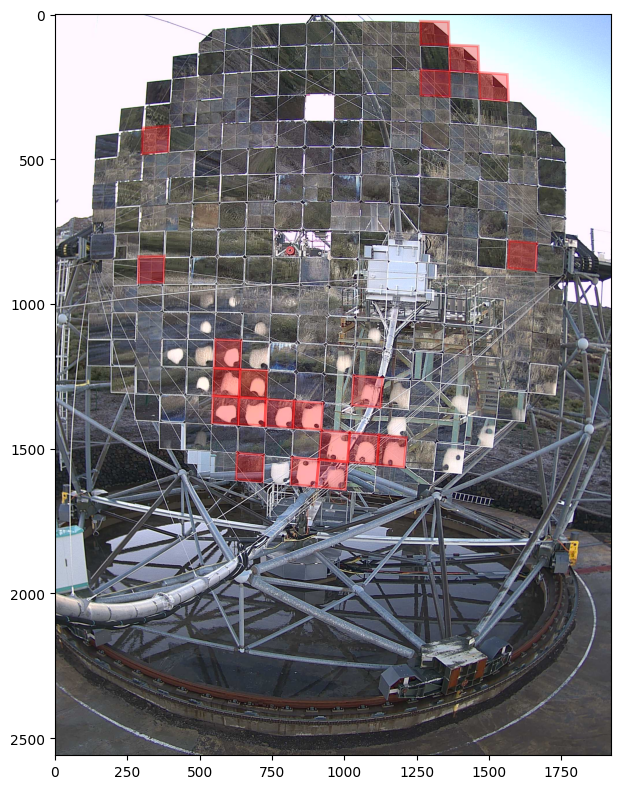

In [147]:
p_list = []
for m_id in outliers:
    p_list.append(mirror_extractor.get_point_coords(m_id))
mark_mirrors_on_img(IMG_PATH, p_list)

In [ ]:


mirror_extractor = SimpleMirrorExtractor(str(MIRROR_POINTS_JSON))
mirror_feature_extractor = MirrorFeatureExtractor()

feature_names = ['lbp_mean', 'lbp_std', 'lbp_entropy',
                 'glcm_contrast', 'glcm_dissimilarity',
                 'glcm_homogeneity', 'glcm_energy', 'glcm_correlation']

feature_matrix = np.zeros((249, 8))  # wypełniasz w pętli po lustrach

for photo_path in sorted(ROOT.glob("*1005*.jpg")):
    print(photo_path)
    img_bgr = cv2.imread(str(photo_path))  # Path → str required by OpenCV
    if img_bgr is None:
        print(f"  Warning: could not read {photo_path}, skipping.")
        continue
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    mirror_crop = mirror_extractor.extract_mirror_gray(img_gray, mirror_id=150)



In [ ]:
plt.imshow(mirror_crop)

In [ ]:
mirror_crop = mirror_extractor.extract_mirror(img_rgb, mirror_id=248)

In [ ]:
mirror_feature_extractor.extract_texture_features(mirror_crop)

In [ ]:
def get_datetime(photo_path):
    pattern = r"T(\d{4})(\d{2})(\d{2})_(\d{2})(\d{2})(\d{2})"
    match = re.search(pattern, photo_path)
    if match:
        dt = datetime(*map(int, match.groups()))
        return dt

In [ ]:
get_datetime(str(photo_path).split("/")[-1])

In [ ]:
def get_outlier_mirrors(feature_array, sigma=3):
    med = np.median(feature_array)
    mad = np.median(np.abs(feature_array - med))
    z = (feature_array - med)/ (mad*1.4826) # Mnożnik 1.4826 przelicza MAD na jednostki porównywalne ze standardowym odchyleniem (dla rozkładu normalnego).
    return np.where(np.abs(z)>sigma)

In [ ]:
# Single image

IMG_PATH = "/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/data/images_for_analysis/IRCamM1T20251005_075000M.jpg"
IMG_PATH = "/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/data/2025/12/15/IRCamM1T20251215_081547M.jpg"

mirror_extractor = SimpleMirrorExtractor(str(MIRROR_POINTS_JSON))
mirror_feature_extractor = MirrorFeatureExtractor()

feature_names = ['lbp_entropy', 'glcm_contrast', 'glcm_dissimilarity',
                 'glcm_homogeneity', 'glcm_energy', 'glcm_correlation']

feature_matrix = np.zeros((249, 6))  # wypełniasz w pętli po lustrach

img_bgr = cv2.imread(str(IMG_PATH))
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

for mirror_id in range(0, 249):
    mirror_crop = mirror_extractor.extract_mirror_gray(img_gray, mirror_id=mirror_id)
    feat=mirror_feature_extractor.extract_texture_features(mirror_crop)
    feature_matrix[mirror_id] = list(feat.values())

z_matrix = np.zeros_like(feature_matrix)
for j in range(6):
    col = feature_matrix[:, j]
    med = np.median(col)
    mad = np.median(np.abs(col - med))*1.4826 # robust "std"
    if mad > 1e-10:
        z_matrix[:, j] = (col - med)/ mad
# ─── KROK 2: Odwróć cechy gdzie "wiecej = gorzej" ───
# Chcemy: wyzszy z-score = lepsze lustro, wszedzie

flip_columns = {
    'glcm_contrast': 1,       # wysoki kontrast = brudne lustro
    'glcm_dissimilarity': 2,  # wysoka roznorodnosc = brudne
    'lbp_entropy': 0,         # wysoka entropia = chaotyczna tekstura
}

for name, idx in flip_columns.items():
    z_matrix[:, idx] *= -1

composite = z_matrix.mean(axis=1)
# composite[i] > 0  → lustro i lepsze niz typowe
# composite[i] < 0  → lustro i gorsze niz typowe
# composite[i] < -2 → lustro i wyraznie gorsze

threshold = -1.2
outliers = np.where(composite < threshold)[0]
print(f"Znaleziono {len(outliers)} outlierow:")